[*********************100%***********************]  1 of 1 completed


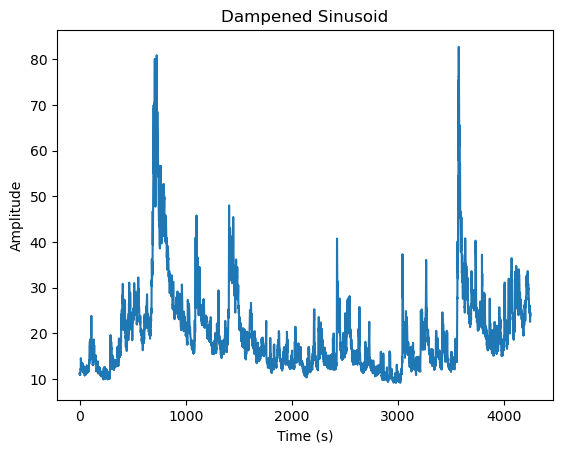

In [197]:
import numpy as np
#Import the Generator from utils- Reload the module to get the latest version
from importlib import reload
import utils
reload(utils)
from utils import series_generator
from utils import stock_price_generator
import matplotlib.pyplot as plt




#Simulate and plot a dampened sinusoid in time



#Genrate the series or download stock data

#y, y_train, y_test, t = series_generator(2500)
y, y_train, y_test, t = stock_price_generator('^VIX')
T, T_train, T_test = len(y), len(y_train), len(y_test)



# Plot the function
plt.plot(t, y)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Dampened Sinusoid')
plt.show()



In [198]:
import Models
reload(Models)
from Models import Net
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils

#Preprocess the data to normalize them using the training statistics

y_train_zscore = (y_train - np.mean(y_train)) / np.std(y_train)
y_zscore = (y - np.mean(y_train)) / np.std(y_train)


#Define the model, loss function, and optimizer and train it for 100 epochs.

net = Net()
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), weight_decay=1e-5)
net.train()

for epoch in range(100):  # loop over the dataset multiple times

    running_loss = 0.0
    for i in range(0, T_train - 200, 50):
        # get the inputs; data is a list of [inputs, labels]
        inputs=y_train_zscore[i:i+200]
        inputs = torch.tensor(inputs)
        labels = torch.tensor(y_train_zscore[i+200:i+250])

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs.float())
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    print('[%d] loss: %.10f' %
            (epoch + 1, running_loss))
    running_loss = 0.0

print('Finished Training')

[1] loss: 61.8020073026
[2] loss: 46.6584513579
[3] loss: 45.5204074066
[4] loss: 36.4983711727
[5] loss: 30.9157216400
[6] loss: 26.1874278318
[7] loss: 32.8080231119
[8] loss: 32.2992016766
[9] loss: 17.2356351689
[10] loss: 24.5707156267
[11] loss: 19.4248884916
[12] loss: 13.4093006998
[13] loss: 11.2261724006
[14] loss: 9.9615764786
[15] loss: 11.5010375464
[16] loss: 9.7001654096
[17] loss: 12.4680222422
[18] loss: 11.3046952933
[19] loss: 9.0174216945
[20] loss: 7.8718489110
[21] loss: 9.1590713011
[22] loss: 9.7993116751
[23] loss: 8.6717450265
[24] loss: 13.3249142645
[25] loss: 5.7742262483
[26] loss: 6.9754459006
[27] loss: 8.3605359332
[28] loss: 18.0729587665
[29] loss: 12.9485569745
[30] loss: 24.6351669822
[31] loss: 6.9621719522
[32] loss: 7.3865133370
[33] loss: 8.0066855103
[34] loss: 12.9895912749
[35] loss: 10.2628570427
[36] loss: 21.1605772860
[37] loss: 6.0418067640
[38] loss: 10.7557733830
[39] loss: 8.4399250872
[40] loss: 14.6662739199
[41] loss: 7.0288581424


In [199]:
#Test the model on the entire data set and plot the results.
net.eval()
y_pred = []
for i in range(0, T - 200, 50):
    inputs=y_zscore[i:i+200]
    inputs = torch.tensor(inputs)
    outputs = net(inputs.float())
    y_pred.append(outputs.detach().numpy())

y_pred = np.array(y_pred)
y_pred = y_pred.reshape(T-200)
#Denormalize the prediction
y_pred = y_pred*np.std(y_train) + np.mean(y_train)


#plot with plotly with a line where the training set ends
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=t[0:T], y=y, mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=t[200:T], y=y_pred, mode='lines', name='Predicted'))
fig.add_trace(go.Scatter(x=[t[T_train], t[T_train]], y=[-20, 150], mode='lines', name='Training Set End'))
fig.update_layout(title='Dampened Sinusoid', xaxis_title='Time (s)', yaxis_title='Amplitude')
fig.show()

#Compute the total error on the test set.
error = 0
for i in range(T_train, T):
    error = error + (y[i] - y_pred[i-200])**2
error = error/T_test
print(error)


85.87252844190166


Optimal parameters:  alpha_mu = 0.8357295988316786,  alpha_sigma = 0.08041444501930584, mu_0 = 11.313135054710358, sigma2_0 = 1e-06, beta_mu = 0.9894714065808661, beta_sigma = 0.9202067238158605, omega_mu = 0.1633809261393706, omega_sigma = 0.09057048040806333, nu = 4.318267106096297


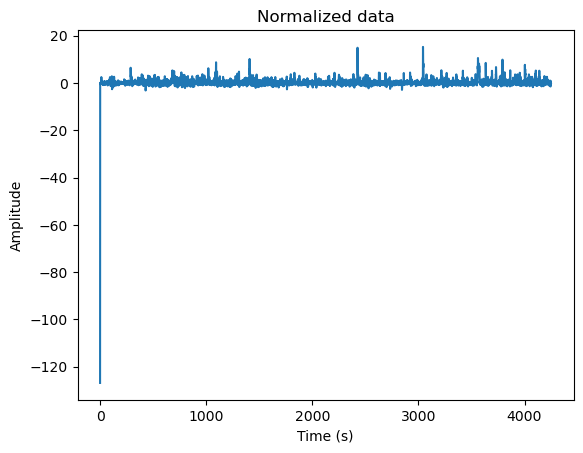

The share of points that are outside the 95% variability interval is 4.235294117647059%
The share of y t+1 that are outside the 95% variability interval is 7.8352941176470585%


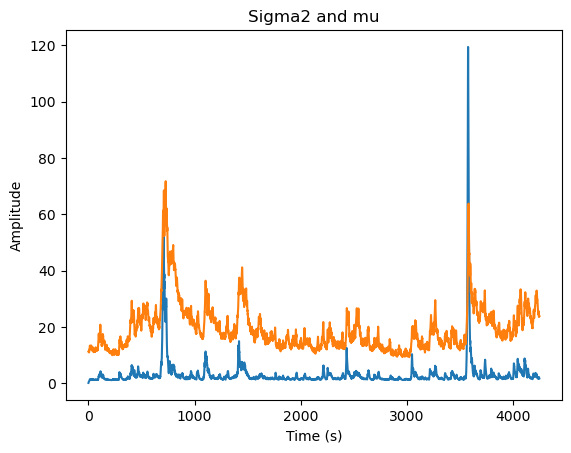

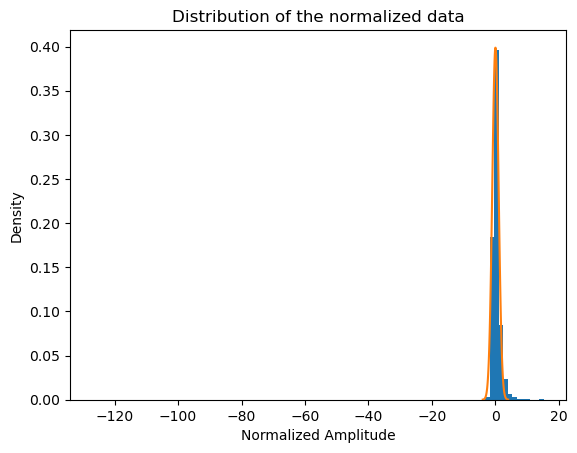

In [200]:
import GAS_norm
reload(GAS_norm)
from GAS_norm import SD_Normalization_Gaussian 
from GAS_norm import SD_Normalization_Student
import numpy as np

#Set the normalization strngth for the mean and the variance from 0 to 1
mean_norm_strength = 1
var_norm_strength = 1

norm_strength = [mean_norm_strength*0.5, var_norm_strength*0.5]
#mu_list, sigma2_list, y_norm = SD_Normalization_Gaussian(y, y_train, 'Full', mode='predict', norm_strength=[0.5, 0.5])
mu_list, sigma2_list, y_norm, alpha_mu, alpha_sigma, beta_mu, beta_sigma, omega_mu, omega_sigma, nu = SD_Normalization_Student(y, y_train,  mode='predict', norm_strength=norm_strength)



#Plot the normalized data

plt.plot(t[0:T], y_norm)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Normalized data')
plt.show()

#Plot the original data with the predicted mean and 95% variability interval

import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=t[0:T], y=y, mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=t[0:T], y=mu_list, mode='lines', name='Predicted'))
fig.add_trace(go.Scatter(x=t[0:T], y=mu_list+1.96*np.sqrt(sigma2_list), mode='lines', name='Upper Bound'))
fig.add_trace(go.Scatter(x=t[0:T], y=mu_list-1.96*np.sqrt(sigma2_list), mode='lines', name='Lower Bound'))
fig.update_layout(title='Dampened Sinusoid', xaxis_title='Time (s)', yaxis_title='Amplitude')
fig.show()


#Write the share of points that are outside the 95% variability interval

share = np.sum((y > mu_list+1.96*np.sqrt(sigma2_list)) | (y < mu_list-1.96*np.sqrt(sigma2_list)))/len(y)
print("The share of points that are outside the 95% variability interval is {}%".format(share*100))

#Write the share of y_{t+1} that are outside the 95% variability interval

share = np.sum((y[1:] > mu_list[0:-1]+1.96*np.sqrt(sigma2_list[0:-1])) | (y[1:] < mu_list[0:-1]-1.96*np.sqrt(sigma2_list[0:-1])))/len(y)
print("The share of y t+1 that are outside the 95% variability interval is {}%".format(share*100))

#Plot sigma_list and mu_list in the same plot
plt.plot(t[0:T], sigma2_list)
plt.plot(t[0:T], mu_list)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Sigma2 and mu')
plt.show()

#Plot the distributino of the normalized and unormalized data and compare it with a standard normal distribution

import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np

plt.hist(y_norm, bins=100, density=True)
plt.plot(np.linspace(-4, 4, 100), stats.norm.pdf(np.linspace(-4, 4, 100), 0, 1))
plt.xlabel('Normalized Amplitude')
plt.ylabel('Density')
plt.title('Distribution of the normalized data')
plt.show()



In [201]:
#Redo the training with the new strategy
import Models
reload(Models)
from Models import GAS_Net
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils


#Divide the data into training and testing sets. The first 1500 time steps of y will be used for training and the last 1000 for testing.

y_norm_train = y_norm[0:T_train]
y_norm_test = y_norm[T_train:T]

#Define the model, loss function, and optimizer and train it for 100 epochs.
#The training is divided in more phases to avoid gradients size problems.
#We first train only the mu layer to make linear predictions with mean information. All the rest is set to zero. 
#Then we fix the mu layer and train the nonlinear part. 
#Fianllly we train the sigma layer.


gas_net = GAS_Net()
gas_net.float()
gas_net.train()
criterion = nn.MSELoss()
model_parameters = gas_net.named_parameters()
optimizer_mu = optim.Adam([param for name, param in model_parameters if 'mu_layer' in name], weight_decay=1e-5)
model_parameters = gas_net.named_parameters()
optimizer_eps = optim.Adam([param for name, param in model_parameters if 'fc1' in name or 'fc2' in name or 'fc3' in name or 'relu' in name], weight_decay=1e-5)
model_parameters = gas_net.named_parameters()
optimizer_sigma = optim.Adam([param for name, param in model_parameters if 'sigma_layer' in name], weight_decay=1e-5)
optimizer_list = [optimizer_mu, optimizer_eps, optimizer_sigma]

for phase in range(2):
    optimizer = optimizer_list[phase]
    for epoch in range(100):  # loop over the dataset multiple times
        running_loss = 0.0
        for i in range(0, T_train - 200, 50):
            # get the inputs; data is a list of [inputs, labels]
            
            inputs=y_norm_train[i:i+200]
            inputs = torch.tensor(inputs)
            labels = torch.tensor(y_train[i+200:i+250])
            mu_vector = torch.tensor(mu_list[i:i+200])
            sigma2_vector = torch.tensor(sigma2_list[i:i+200])

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = gas_net(inputs.float(), mu_vector.float(), sigma2_vector.float(), 1)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # print statistics
            running_loss += loss.item()
        print('[%d] loss: %.10f' %
                (epoch + 1, running_loss))
        running_loss = 0.0

print('Finished Training')

[1] loss: 9254.8388991356
[2] loss: 5420.0355210304
[3] loss: 4881.0219459534
[4] loss: 4499.0809502602
[5] loss: 4242.8510963917
[6] loss: 4065.4386343956
[7] loss: 3934.3633050919
[8] loss: 3830.5167860985
[9] loss: 3743.0557949543
[10] loss: 3665.9024515152
[11] loss: 3595.6745221615
[12] loss: 3530.4899711609
[13] loss: 3469.2847743034
[14] loss: 3411.4336822033
[15] loss: 3356.5443227291
[16] loss: 3304.3468089104
[17] loss: 3254.6387076378
[18] loss: 3207.2521710396
[19] loss: 3162.0414979458
[20] loss: 3118.8739805222
[21] loss: 3077.6246571541
[22] loss: 3038.1764431000
[23] loss: 3000.4176988602
[24] loss: 2964.2421369553
[25] loss: 2929.5483825207
[26] loss: 2896.2401883602
[27] loss: 2864.2272303104
[28] loss: 2833.4246232510
[29] loss: 2803.7517652512
[30] loss: 2775.1343947649
[31] loss: 2747.5028651953
[32] loss: 2720.7929573059
[33] loss: 2694.9450054169
[34] loss: 2669.9037426710
[35] loss: 2645.6188001633
[36] loss: 2622.0434478521
[37] loss: 2599.1349128485
[38] loss:

In [202]:
#Test the model on the entire data set and plot the results.
gas_net.eval()
y_pred = []
for i in range(0, T - 200, 50):
    inputs=y_norm[i:i+200]
    inputs = torch.tensor(inputs)
    mu_vector = torch.tensor(mu_list[i:i+200])
    sigma2_vector = torch.tensor(sigma2_list[i:i+200])
    outputs = gas_net(inputs.float(), mu_vector.float(), sigma2_vector.float(), 1)
    y_pred.append(outputs.detach().numpy())

y_pred = np.array(y_pred)
y_pred = y_pred.reshape(T-200)

#plot with plotly with a line where the training set ends

import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=t[0:T], y=y, mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=t[200:T], y=y_pred, mode='lines', name='Predicted'))
fig.add_trace(go.Scatter(x=[t[T_train], t[T_train]], y=[-20, 150], mode='lines', name='Training Set End'))
fig.update_layout(title='Dampened Sinusoid', xaxis_title='Time (s)', yaxis_title='Amplitude')
fig.show()

#Compute the total error on the test set.

error = 0
for i in range(T_train, T):
    error = error + (y[i] - y_pred[i-200])**2
error = error/T_test
print(error)

100.16143409558971


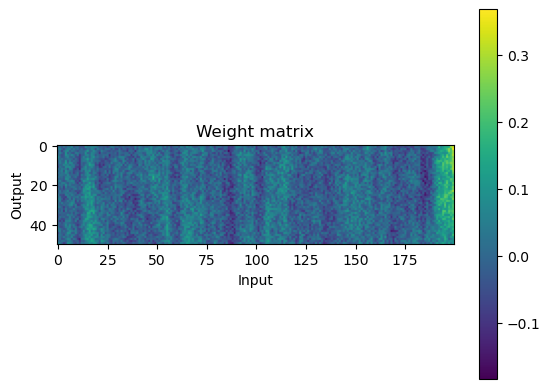

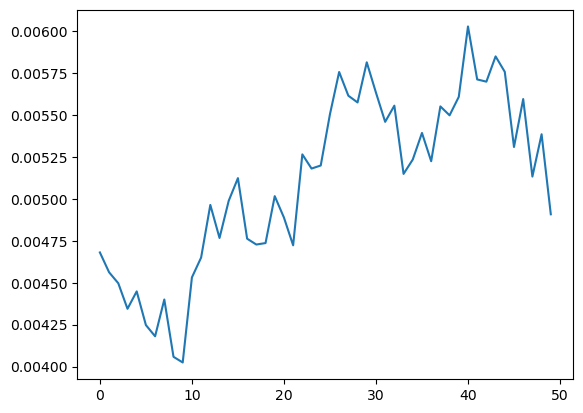

In [203]:
#Plot the weight matrix of the last layer of the network as an heatmap and add the legend of the colorbar

weights = gas_net.mu_layer.weight.detach().numpy()
plt.imshow(weights)
plt.colorbar()
plt.xlabel('Input')
plt.ylabel('Output')
plt.title('Weight matrix')

plt.show()

#Now plot the mean of the weights with respect to each input

weights = gas_net.mu_layer.weight.detach().numpy()
plt.plot(weights.mean(axis=1))






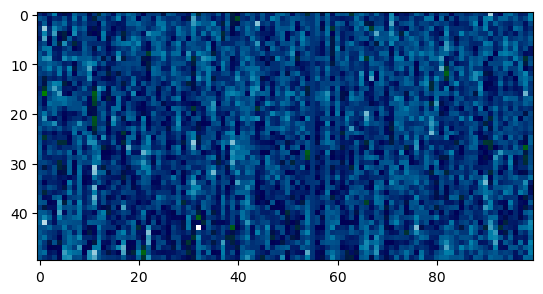

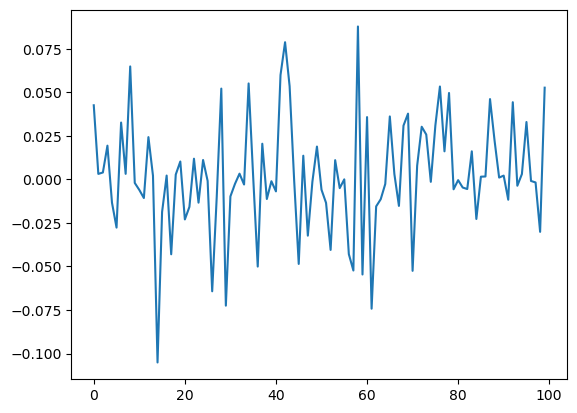

In [204]:
#Plot the weight matrix of the last layer of the network as an heatmap

weights = gas_net.fc3.weight.detach().numpy()
plt.imshow(weights, interpolation='nearest', cmap=plt.cm.ocean)

plt.show()

#Now plot the mean of the weights with respect to each input

weights = gas_net.fc3.weight.detach().numpy()
plt.plot(weights.mean(axis=0))


In [205]:
#Define a neural network class that use Revin as normalization procedure
#Revin expect the input and output to be (batch, time, features) so we need to reshape the data
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils


In [206]:
import Models
reload(Models)
from Models import Revin_Net


#Define the model, loss function, and optimizer and train it for 100 epochs.

net = Revin_Net()
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), weight_decay=1e-5)
net.train()

for epoch in range(100):  # loop over the dataset multiple times

    running_loss = 0.0
    for i in range(0, T_train - 200, 50):
        # get the inputs; data is a list of [inputs, labels]
        inputs=y_train[i:i+200]
        inputs = torch.tensor(inputs)
        labels = torch.tensor(y_train[i+200:i+250])

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs.float())
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    print('[%d] loss: %.10f' %
            (epoch + 1, running_loss))
    running_loss = 0.0

print('Finished Training')

[1] loss: 4074.4478801489
[2] loss: 3334.2797102928
[3] loss: 2455.5634732246
[4] loss: 2206.0816171169
[5] loss: 1686.5358091593
[6] loss: 1223.1667158604
[7] loss: 1028.8706178665
[8] loss: 845.6479931474
[9] loss: 790.0757323503
[10] loss: 698.8542590141
[11] loss: 748.9306373894
[12] loss: 625.4482280612
[13] loss: 563.5115531087
[14] loss: 500.5564949512
[15] loss: 438.8548953533
[16] loss: 474.9009838700
[17] loss: 479.5772058368
[18] loss: 543.2783585787
[19] loss: 456.7383973598
[20] loss: 454.4073126316
[21] loss: 546.9951381087
[22] loss: 386.6850351095
[23] loss: 451.6692910194
[24] loss: 394.3607769012
[25] loss: 345.8297086954
[26] loss: 280.9072267115
[27] loss: 330.7841719985
[28] loss: 328.4682179987
[29] loss: 415.1797745228
[30] loss: 291.6698428392
[31] loss: 276.8607634902
[32] loss: 219.0582768619
[33] loss: 235.4568493366
[34] loss: 233.9432453215
[35] loss: 246.1623477638
[36] loss: 217.4867011607
[37] loss: 208.6867793500
[38] loss: 213.0723959804
[39] loss: 211

In [207]:
#Test the model on the entire data set and plot the results.
net.eval()
y_pred = []
for i in range(0, T - 200, 50):
    inputs=y[i:i+200]
    inputs = torch.tensor(inputs)
    outputs = net(inputs.float())
    y_pred.append(outputs.detach().numpy())

y_pred = np.array(y_pred)
y_pred = y_pred.reshape(T - 200)

#plot with plotly with a line where the training set ends
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=t[0:T], y=y, mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=t[200:T], y=y_pred, mode='lines', name='Predicted'))
fig.add_trace(go.Scatter(x=[t[T_train], t[T_train]], y=[-20, 150], mode='lines', name='Training Set End'))
fig.update_layout(title='Dampened Sinusoid', xaxis_title='Time (s)', yaxis_title='Amplitude')
fig.show()

#Compute the total error on the test set.
error = 0
for i in range(T_train, T):
    error = error + (y[i] - y_pred[i-200])**2
error = error/T_test
print(error)

111.67887595729435


## Autoregressive GAS Test

In [210]:
#Redo the training with the new strategy
import Models
reload(Models)
from Models import AR_GAS_Net
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils


#Divide the data into training and testing sets. The first 1500 time steps of y will be used for training and the last 1000 for testing.

y_norm_train = y_norm[0:T_train]
y_norm_test = y_norm[T_train:T]

#Define the model, loss function, and optimizer and train it for 100 epochs.
#The training is divided in more phases to avoid gradients size problems.
#We first train only the mu layer to make linear predictions with mean information. All the rest is set to zero. 
#Then we fix the mu layer and train the nonlinear part. 
#Fianllly we train the sigma layer.


ar_gas_net = AR_GAS_Net(k = 50, use_deep_preds=False)
ar_gas_net.float()
ar_gas_net.train()
criterion = nn.MSELoss()
optimizer = optim.Adam(ar_gas_net.parameters(), weight_decay=1e-5)

for epoch in range(100):  # loop over the dataset multiple times
    running_loss = 0.0
    for i in range(0, T_train - 200, 50):
        # get the inputs; data is a list of [inputs, labels]
        
        inputs=y_norm_train[i:i+200]
        inputs = torch.tensor(inputs)
        labels = torch.tensor(y_train[i+200:i+250])
        last_mu = torch.tensor(mu_list[i+199])
        last_sigma2 = torch.tensor(sigma2_list[i+199])

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = ar_gas_net(inputs.float(), last_mu.float(), last_sigma2.float(), alpha_mu, alpha_sigma, beta_mu, beta_sigma, omega_mu, omega_sigma, nu, norm_strength)
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
    print('[%d] loss: %.10f' %
            (epoch + 1, running_loss))
    running_loss = 0.0

[1] loss: 1908.5417193174
[2] loss: 1908.5417193174
[3] loss: 1908.5417193174
[4] loss: 1908.5417193174
[5] loss: 1908.5417193174
[6] loss: 1908.5417193174
[7] loss: 1908.5417193174
[8] loss: 1908.5417193174


KeyboardInterrupt: 

In [211]:
#Test the model on the entire data set and plot the results.
ar_gas_net.eval()
y_pred = []

for i in range(0, T - 200, 50):
    inputs=y_norm[i:i+200]
    inputs = torch.tensor(inputs)
    last_mu = torch.tensor(mu_list[i+199])
    last_sigma2 = torch.tensor(sigma2_list[i+199])
    outputs = ar_gas_net(inputs.float(), last_mu.float(), last_sigma2.float(), alpha_mu, alpha_sigma, beta_mu, beta_sigma, omega_mu, omega_sigma, nu, norm_strength)
    y_pred.append(outputs.detach().numpy())

y_pred = np.array(y_pred)
y_pred = y_pred.reshape(T-200)

#plot with plotly with a line where the training set ends
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=t[0:T], y=y, mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=t[200:T], y=y_pred, mode='lines', name='Predicted'))
fig.add_trace(go.Scatter(x=[t[T_train], t[T_train]], y=[-20, 150], mode='lines', name='Training Set End'))
fig.update_layout(title='Dampened Sinusoid', xaxis_title='Time (s)', yaxis_title='Amplitude')
fig.show()

#Compute the total error on the test set.
error = 0
for i in range(T_train, T):
    error = error + (y[i] - y_pred[i-200])**2
error = error/T_test
print(error)

89.75531060833502
